<a href="https://colab.research.google.com/github/MichelleAppel/wavefunction-collapse/blob/main/Appel_Practical_WFC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

```
SOW-MKI95 Computer Graphics & Computer Vision
Wave function collapse
```

```
Group number: ...
Student 1 name/number: ...
Student 2 name/number: ...
...
```

In [238]:
import collections

from PIL import Image

import numpy as np

# Wave function collapse

In quantum mechanics, WFC is the phenomenon where a wave function ("all possible trajectories in superposition") gets transformed into a localized ("collapsed") particle upon interaction with a detector. [The WFC algorithm](https://github.com/mxgmn/WaveFunctionCollapse) for procedural texture synthesis is loosely inspired on this phenomenon: it initializes a bitmap where each $N \times N$ patch is in superposition of all possible patterns (max. entropy). Upon (random) detection by the algorithm, a patch collapses into a state of certainty (min. entropy). Importantly, not all patterns are allowed to be adjacent to each other such that a collapsed state influences the possible states of its neighboring patches and their neighbors and so on and so forth. When the algorithm finishes, you have a newly synthesized tilemap.



## Task 1: Create constraint dictionary (30 points)

Choose an input bitmap from [here](https://github.com/mxgmn/WaveFunctionCollapse/tree/master/samples). Load and plot it.

Set a patch size (e.g., 4 $\times$ 4 pixels) and build a dictionary of all the patches in this bitmap image and their direct neighbors. Our to-be-synthesized bitmap will check this dictionary to see which patterns can live next to each current patch.

One way to store the neighboring constraints is by setting each key to be the current patch (tuple of flattened pixel values) and its values to be a tuple of five values: up_neighbbors (list), right_neighbbors (list), bottom-neighbbors (list), left-neighbbors (list), weight (int). Each list will store the possible neighbors (list of tuples of flattened pixel values). The weight $w$ is the total number of possible neighbors which we will need later to compute the entropy of a patch. Note that you can simply add more neighbors to each list if a key already exists in the dictionary.

*Bonus: augment the possible states in your dictionary with rotations and reflections. Make sure your augmentations make sense; it is not realistic if plants grow out of the sky (unless it's what you intend to create).*

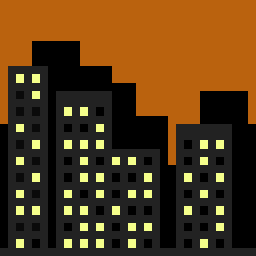

In [239]:
bitmap = Image.open('Skyline2.png')
bitmap.resize((256, 256), resample=0)

In [240]:
def sliding_window(image, stepSize, windowSize):
  for y in range(0, image.shape[0]-windowSize[0]+1, stepSize):
    for x in range(0, image.shape[1]-windowSize[1]+1, stepSize):
      patch = image[y:y + windowSize[1], x:x + windowSize[0]]
      up_neighbour = image[y - windowSize[1]:y, x:x + windowSize[0]]
      down_neighbour = image[y + windowSize[1]:y + 2*windowSize[1], x:x + windowSize[0]]
      left_neighbour = image[y - windowSize[1]:y, x - windowSize[0]:x]
      right_neighbour = image[y - windowSize[1]:y, x + windowSize[0]:x + 2*windowSize[0]]
      yield (patch, [up_neighbour], [down_neighbour], [left_neighbour], [right_neighbour])

In [241]:
def to_array(tup, size):
  return np.array(tup).reshape(size, size, 3)

In [242]:
def to_tuple(array):
  return tuple(array.flatten())

In [243]:
def to_image(array):
  return Image.fromarray(array)

In [244]:
def tuple_to_image(tup, size):
  return to_image(to_array(tup, size))

In [245]:
def blend(img1, img2, alpha=0.5):
  return Image.blend(img1, img2, alpha)

In [246]:
def blend_and_visualize(img1, img2, alpha=0.5):
  return blend(img1, img2, alpha).resize((128, 128), resample=0)

In [247]:
def visualize(array):
  bitmap = Image.fromarray(array)
  return bitmap.resize((128, 128), resample=0)

In [248]:
patch_size = 4
bitmap_array = np.array(bitmap)[:, :, :-1]

neighbour_dict = {} # The dictonary that will store all neighbours
patches = sliding_window(bitmap_array, 1, (patch_size, patch_size)) # A generator for the patches
for patch in patches:
  key = to_tuple(patch[0])
  neighbours = list(patch[1:])
  if key in neighbour_dict.keys():
    for i in range(len(neighbours)):
      neighbour_dict[key][i] += neighbours[i]
      neighbour_dict[key][-1] += 1
  else:
    neighbour_dict[key] = neighbours + [1]

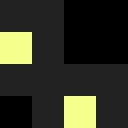

In [249]:
# Example patch
k = list(neighbour_dict.keys())[200]
visualize(to_array(k, 4))

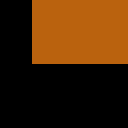

In [250]:
# Upstairs neighbour
neighbours = neighbour_dict[k]
visualize(to_array(neighbours[3][0], 4))

You specify the dimensions of your output (to-be-synthesized) bitmap to be $M \times M$ patches. In the beginning, all the patches within this bitmap are in **superposition** which means that every pattern is possible at every position. When the algorithm starts with observation-and-propagation, it is important to keep track of two values per patch:

- Potential
- Entropy

Potential is a boolean array of shape $M \times M \times total\_num\_patterns$ where each entry is initially set to True (because everything is possible when a patch is in superposition). It keeps track of all the possible patterns that each patch can collapse to. 

Entropy is computed as follows:

\begin{equation}
    E = - p * \log_2 p + ϵ
\end{equation}

where $p$, for each patch, can be computed as $w$ / sum(all $w$) * sum(potential). Initially, all patches have the same full potential (i.e. $total\_num\_patterns$) and thus the same (max.) entropy. For this reason, we add some small random number ϵ to help the algorithm decide which patch to select first based on entropy.

## Task 2 Create the wave (30 points)


Create an output bitmap of $M \times M$ patches. Each patch within this output image is of size $N \times N \times 3$ pixels. Plot the (initial) wave image where all patches are in superposition by doing the following for each patch in the output bitmap:

1. Check where potential is set to True and take the corresponding patterns
2. Blend all these patterns (e.g., use Image.blend() from PIL)



In [319]:
M = 8

all_patches = list(neighbour_dict.keys())

potential = np.ones((M, M, len(all_patches)), dtype=bool)

In [320]:
entropy = []

all_w = []
for patch in all_patches:
  all_w += [neighbour_dict[patch][4]]

In [321]:
sum_w = sum(all_w)
mean_w = np.array(all_w)/sum_w
p = np.expand_dims(potential.sum(-1), -1) * mean_w

In [322]:
epsilon = np.random.rand(*p.shape)/10
entropy = -p*np.log2(p) + epsilon

In [323]:
average_patch = np.array(np.array(all_patches).reshape(len(all_patches),4,4,3).mean(0), dtype=np.uint8)

In [324]:
init_map = np.zeros((potential.shape[0]*patch_size, potential.shape[1]*patch_size, 3), dtype=np.uint8)

for x in range(0, len(potential)):
  for y in range(0, len(potential[x])):
    mean_patch = np.array(all_patches)[potential[x][y]].mean(0)
    init_map[patch_size*x:patch_size*x+patch_size, patch_size*y:patch_size*y+patch_size] = np.array(mean_patch.reshape(4,4,3), dtype=np.uint8)

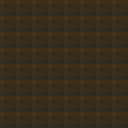

In [325]:
visualize(init_map)

## Task 3 Implement the algorithm (30 points)

WFC repeatedly applies observation and propagation until all patches are collapsed. 

- **Observation:** take the patch with the lowest entropy and collapse its state. When a patch is collapsed, set the respective potential entry to True and all the other entries to False. Set its entropy to infinite.
- **Propagation:** update all the other patches such that impossible neighbors are set to to false. You may use the stack below to do this: push neighbors to the stack if they need to be checked/updated and pop patches from the stack that you just visited and whose potential has been updated. In the end, make sure entropy is updated too.

In [ ]:
class Stack:
    def __init__(self):
        self.deque = collections.deque()

    def __len__(self):
        return self.deque.__len__()

    def peek(self):
        return self.deque[-1]

    def push(self, value):
        self.deque.append(value)

    def pop(self):
        return self.deque.pop()

In [ ]:
###

## Task 4 Create a gif (10 points)

For each observe-propagate cycle, plot and save the (updated) output image. Create a gif from superposition to fully-observed synthesized texture. Submit this gif with your notebook.

In [ ]:
###